- Predict score associated with each player in FPL
- Pack most valuable 11 players with given budget
- For formation in acceptable_formations
    - Choose cheapest GK. 
    - Use knapsack to choose 14 players, score of team is first 11 players. 
    - Key Idea :
        - View team building as 3 different knapsack problems for attackers, defenders and midfielders. 
        - Randomize order of choosing attacker or defender first. 

In [3]:
import numpy as np
import collections
import pandas as pd
import torch
import numpy as np
import random
from random import shuffle
np.random.seed(17)
random.seed(17)
torch.manual_seed(17)
import wget
import os
import aiohttp
import asyncio
from fpl import FPL
from torch.utils.data import TensorDataset, DataLoader
from player import Player
from team import Team
from data_processor import get_fpl, get_current_squad
from agent import Agent
import itertools
from collections import defaultdict
'done'

'done'

In [37]:

def knapsack(weights, values, names, max_weight, num_players, teams = [], teams_dict=defaultdict(int)):
    '''
        Args
            weights - array of length n 
            values - array of length n
            names - array of length n 
            max_weight - max weight that can be put in knapsack 
            num_players - max num of players
        Returns
            subset of values whose sum is maximal and its weight being under max_weight
    '''
    dp = np.zeros((len(weights) + 1, max_weight + 1))
    paths = []
    teams_in_path = []
    for i in range(dp.shape[0]):
        path = []
        team_in_path = []
        for j in range(dp.shape[1]):
            path.append([])
            team_in_path.append([])
        paths.append(path)
        teams_in_path.append(team_in_path)

    for i in range(1, dp.shape[0]):
        for j in range(1, dp.shape[1]):
            is_valid = True
            if len(teams):
                local_teams_dict = defaultdict(int)
                for team in teams_in_path[i-1][j-weights[i-1]]:
                    local_teams_dict[team] += 1
                    if teams_dict[team] >= 3 or local_teams_dict[team] > 3:
                        is_valid = False
            if is_valid and j >= weights[i-1] and (values[i-1] + dp[i-1][j-weights[i-1]] >= dp[i][j-1]) and len(paths[i-1][j-weights[i-1]]) < num_players:
                dp[i][j] = values[i-1] + dp[i-1][j-weights[i-1]]
                paths[i][j].extend(paths[i-1][j-weights[i-1]] + [names[i-1]])
                if len(teams):
                    teams_in_path[i][j].extend(teams_in_path[i-1][j-weights[i-1]] + [teams[i-1]])
                    local_teams_dict[teams[i-1]] += 1
            else:
                dp[i][j] = dp[i-1][j]
                paths[i][j] = list(paths[i-1][j])
                if len(teams):
                    teams_in_path[i][j] = list(teams_in_path[i-1][j])
    
    best_path = None 
    best_value = -np.inf
    for j in range(len(paths[-1])):
        if dp[-1][j] >= best_value:
            local_teams_dict = defaultdict(int)
            valid = True
            for team in paths[-1][j]:
                local_teams_dict[team] += 1
                if local_teams_dict[team] > 3:
                    valid = False
            if valid:
                best_path = j 
                best_value = dp[-1][j]
    
    
    
    indices = [ names.index(name) for name in paths[-1][best_path] ]
    best_weights = [weights[index] for index in indices]
    best_values = [values[index] for index in indices] 
    return paths[-1][best_path], best_weights, best_values
knapsack(weights=[9, 40, 30, 50, 1], values=[5, 4, 6, 3, 5], names=['a', 'b', 'c', 'd', 'e'], max_weight=50, num_players=3, teams = [2, 1, 1, 1, 1])



(['a', 'c', 'e'], [9, 30, 1], [5, 6, 5])

/home/ajayrfhp/miniconda3/envs/control/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/home/ajayrfhp/Documents/Control/Control_FPL/data_processor.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_player_features["total_points"] = all_player_features["total_points"].clip(0, max_player_points)


(0.7989066391921074, 0.44095987131392544)
Player out


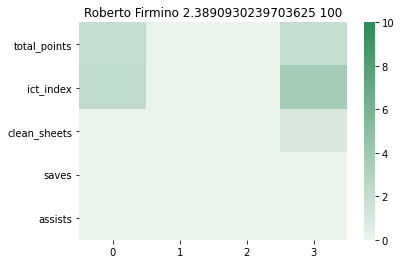

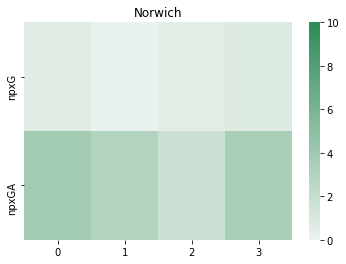

Player in


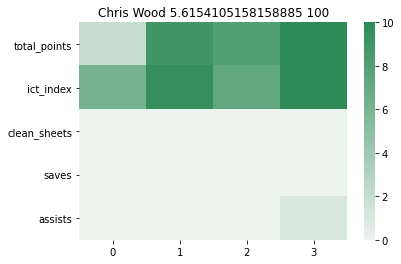

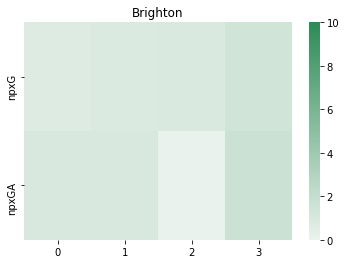

In [5]:
opponent_feature_names = ["npxG","npxGA"]
player_feature_names = ["total_points", "ict_index", "clean_sheets", "saves", "assists"]

agent = Agent(player_feature_names, opponent_feature_names, model_path="./trained_models/player_oppponent_linear_score_model.pt")
await agent.get_data()
await agent.update_model()
current_squad, non_squad = await agent.get_new_squad(player_feature_names, opponent_feature_names)

15
Virgil van Dijk tensor(1.7994) Defender
Trent Alexander-Arnold tensor(4.9507) Defender
Joseph Gomez tensor(1.7994) Defender
Shane Duffy tensor(1.8865) Defender
Bernardo Fernandes Da Silva Junior tensor(1.8865) Defender
Harry Kane tensor(4.5724) Forward
Troy Deeney tensor(4.5472) Forward
Keinan Davis tensor(2.0901) Forward
Ederson Santana de Moraes tensor(4.0134) Goalkeeper
Jed Steer tensor(1.8514) Goalkeeper
Riyad Mahrez tensor(3.0679) Midfielder
Raheem Sterling tensor(3.7977) Midfielder
Phil Foden tensor(3.8402) Midfielder
Jack Harrison tensor(3.6705) Midfielder
Mohamed Naser El Sayed Elneny tensor(2.2544) Midfielder


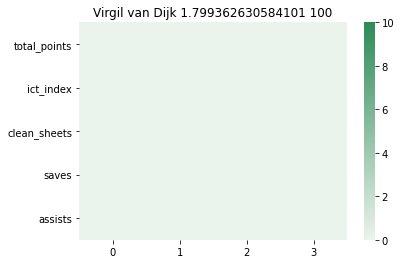

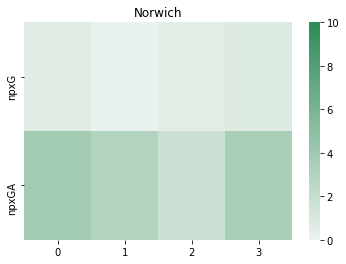

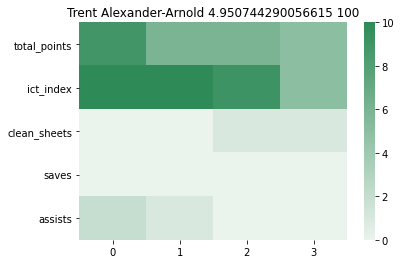

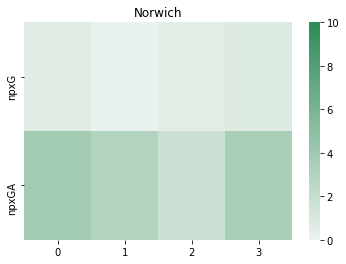

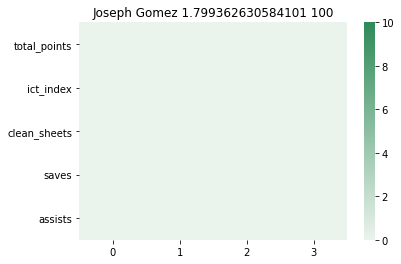

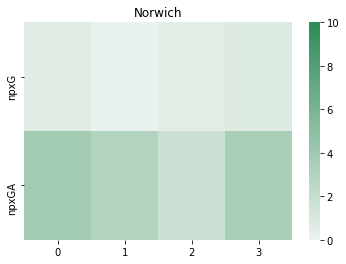

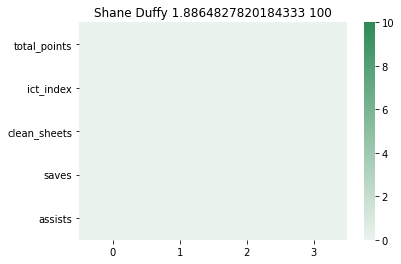

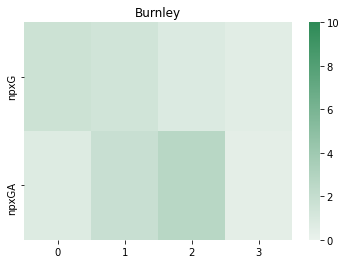

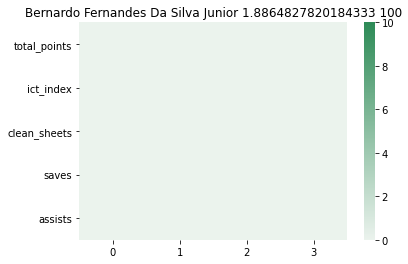

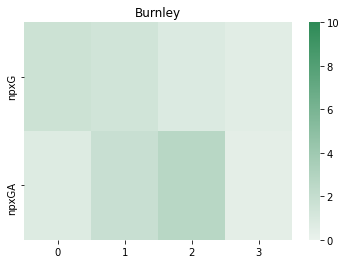

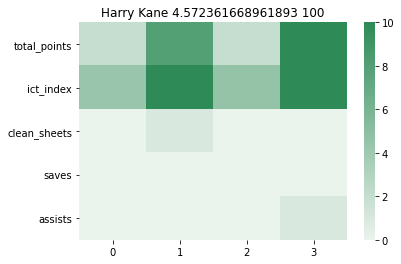

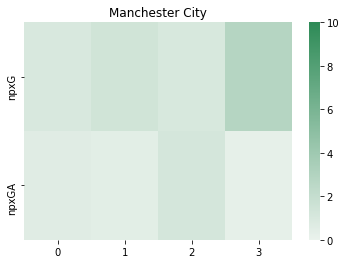

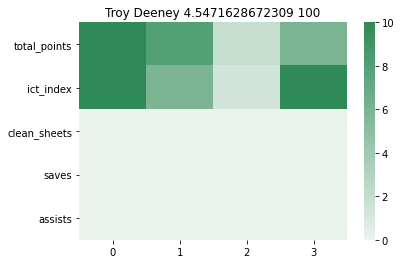

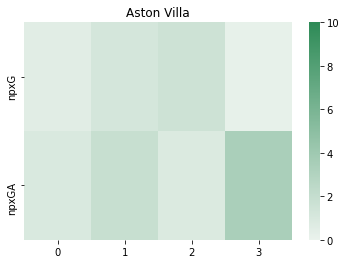

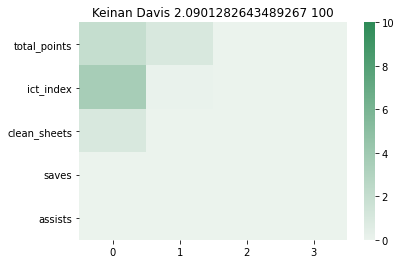

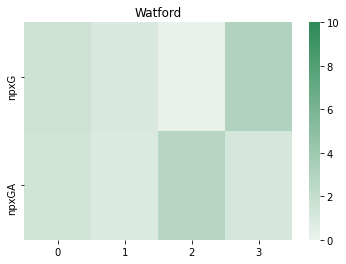

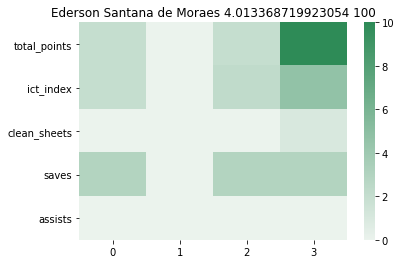

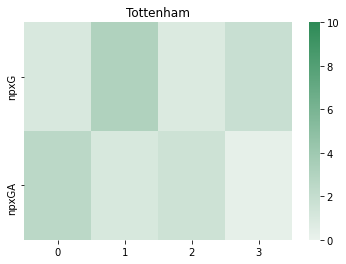

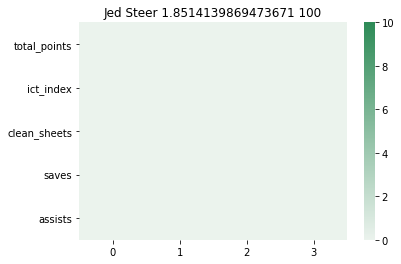

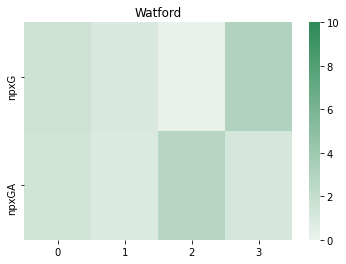

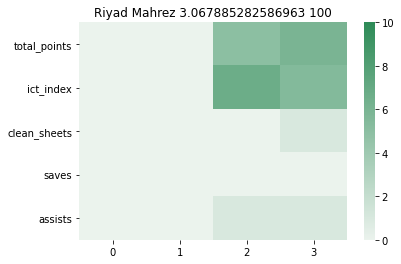

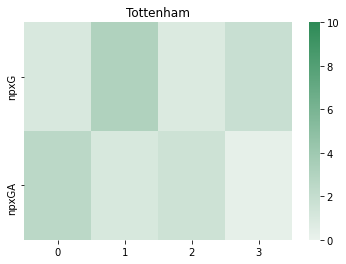

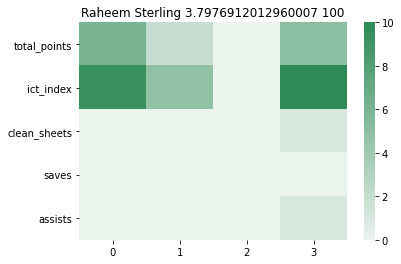

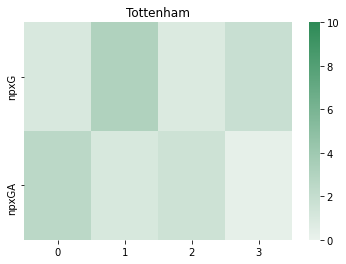

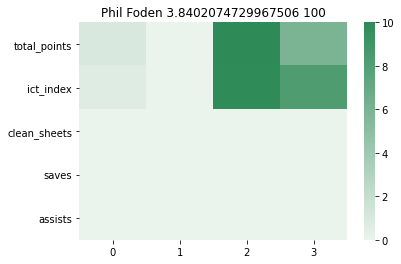

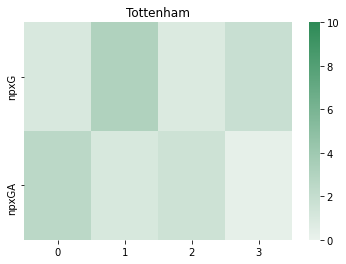

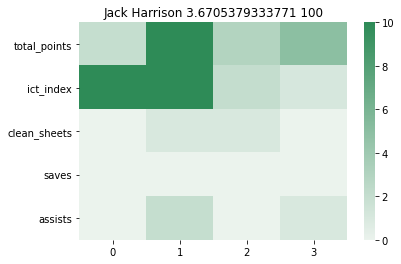

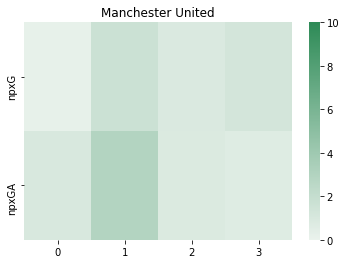

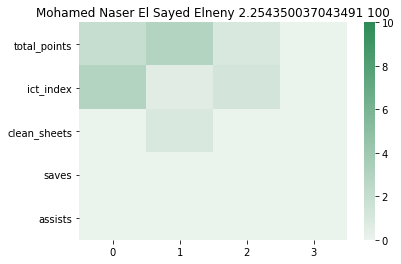

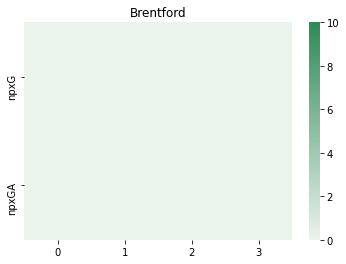

In [40]:
squad = non_squad + current_squad
injuries = pd.read_csv('./data/injuries.csv')['Name'].tolist()
squad = [player for player in squad if player.name not in injuries]

def knapsack_by_position(squad, position, num_players, max_weight, teams_dict):
    players_in_position = [player for player in squad  if player.position == position ]
    
    weights, values, teams = [], [], []
    for player in players_in_position:
        weights.append(player.latest_price)
        total_points = player.player_features[:,0].sum() / 10# lazy approximation
        form_points = player.predicted_performance 
        weighted_points = total_points + form_points
        values.append(weighted_points)
        teams.append(player.team)
    return knapsack(weights=weights, values=values, names=players_in_position, max_weight=max_weight, num_players=num_players, teams=teams, teams_dict=teams_dict), teams_dict

def get_team_by_knapsack(squad, max_weight=1000):
    positions = [('Goalkeeper', 2, 1), ('Defender', 5, 3), ('Midfielder', 5, 4), ('Forward', 3, 2)] # Modeller bias - select 3 contributing defenders, 4 midfielders, 2 forwards and 1 gk. Choose filler players for other posiiton
    best_15, best_value = [], -np.inf
    for (position_ordering) in itertools.permutations(positions):
        budget = max_weight
        potential_best_15, potential_best_value = [], 0
        i = 0
        
        teams_dict = defaultdict(int)
        valid = True
        for position, num_players, num_contribution in position_ordering:
            # choose best 11 by knapsack
            # print(position, num_players, num_contribution, num_contribution+i//2)
            (best_player_in_position, best_weights_in_position, best_values_in_position), teams_dict = knapsack_by_position(squad, position, num_contribution, budget, teams_dict)
            budget -= sum(best_weights_in_position)
            potential_best_15.extend(list(best_player_in_position))
            potential_best_value += sum(best_values_in_position)
            for player in best_player_in_position:
                teams_dict[player.team] += 1
                if teams_dict[player.team] > 3:
                    valid = False
            
            # choose cheap filler players
            players_in_position = [player for player in squad if player.position == position and teams_dict[player.team] <= 2]
            players_in_position = sorted(players_in_position, key = lambda x : x.latest_price)[:(num_players-num_contribution)]
            budget -= sum([player.latest_price for player in players_in_position])
            potential_best_15.extend(players_in_position)  
            for player in players_in_position:
                teams_dict[player.team] += 1
                if teams_dict[player.team] > 3:
                    valid = False
            i += 1
        
        
        potential_best_15 = sorted(potential_best_15, key = lambda x : x.position)
        if potential_best_value >= best_value and len(potential_best_15) == 15:
            best_15 = list(potential_best_15)
            best_value = potential_best_value
    print(len(best_15))
    for player in best_15:
        print(player.name, player.predicted_performance, player.position)
    for player in best_15:    
        player.visualize()


get_team_by_knapsack(squad, 1000)

- Show top performer by position

In [ ]:
agent.show_top_performers(squad, k=5)